In [35]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mne.decoding import CSP
import mne
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline

event_ids = [7,8,9,10]  
event_id_to_label = {}
for i in range(len(event_ids)):
    event_id_to_label[i] = event_ids[i]
print(event_id_to_label)
path = 'data/A02T.gdf'
raw = mne.io.read_raw_gdf(path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
ica = mne.preprocessing.ICA(n_components=len(raw.info['ch_names']), random_state=42, max_iter=1000)
ica.fit(raw)
ica.apply(raw)
csp_filters = {} 
events = mne.events_from_annotations(raw)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
action_dict = {0:'left_hand',1:'right_hand',2:'foot',3:'tongue'}


# Create epochs for all events
all_epochs = mne.Epochs(raw, events[0], event_id=event_ids,  # No specific event_id filtering
                        tmin=2, tmax=6, baseline=None, preload=True)
all_epochs.pick_types(meg=False, eeg=True)

X_all = all_epochs.get_data()
event_ids_all = all_epochs.events[:, -1]
print(X_all.shape,event_ids_all.shape)

{0: 7, 1: 8, 2: 9, 3: 10}
Extracting EDF parameters from c:\DEV\EEG\a2\data\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\Users\ncvn\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 677168  =      0.000 ...  2708.672 secs...
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components
Fitting ICA took 8.7s.
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
(287, 22, 1001) (287,)


In [36]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mne.time_frequency import tfr_array_multitaper

# def plot_raw_mtspecgrams(X, y, fs=250, n_samples=10):
#     """
#     Plot focused mtspecgrams of raw EEG signals with frequency band markers
    
#     Args:
#         X: Shape (n_epochs, n_components, n_timepoints)
#         y: Labels
#         fs: Sampling frequency
#         n_samples: Number of random samples to plot
#     """
#     # Select random indices
#     np.random.seed(1)
#     total_samples = len(X)
#     selected_idx = np.random.choice(total_samples, n_samples, replace=False)
    
#     # Define frequency bands
#     freq_bands = {
#         'Delta': (0.5, 4),
#         'Theta': (4, 8),
#         'Alpha': (8, 13),
#         'Beta': (13, 30),
#         'Gamma': (30, 45)  # Limited to 45 Hz for clearer visualization
#     }
    
#     plt.figure(figsize=(15, 3*n_samples))
    
#     for i, idx in enumerate(selected_idx):
#         plt.subplot(n_samples, 1, i+1)
        
#         # Get single trial data
#         trial_data = X[idx, 0, :]
        
#         # Create frequency array with finer resolution
#         freqs = np.linspace(0.5, 45, 90)  # More detailed frequency resolution
        
#         # Reshape data for mne
#         data = trial_data.reshape(1, 1, -1)
        
#         # Compute TFR with focused parameters
#         tfr = tfr_array_multitaper(data, sfreq=fs, freqs=freqs,
#                                  n_cycles=freqs/2,  # Adjust cycles with frequency
#                                  time_bandwidth=2.0,  # Lower for better frequency resolution
#                                  use_fft=True,
#                                  output='power',
#                                  verbose=False)
        
#         # Get time points
#         times = np.linspace(0, len(trial_data)/fs, tfr.shape[-1])
        
#         # Focus on relevant time window (0.5s to 2.0s)
#         time_mask = (times >= 0) & (times <= 4)
#         times = times[time_mask]
#         tfr = tfr[:,:,:,time_mask]
        
#         # Plot spectrogram
#         plt.pcolormesh(times, freqs, np.squeeze(tfr[0, 0, :, :]),
#                       shading='gouraud', cmap='viridis')
        
#         # Add frequency band marker
#         for band, (fmin, fmax) in freq_bands.items():
#             plt.axhline(y=fmin, color='r', linestyle='--', alpha=0.3)
#             plt.text(times[-1] + 0.1, (fmin + fmax)/2, band, 
#                     verticalalignment='center', fontsize=8)
        
#         plt.title(f'Trial {idx}, Class {y[idx]}')
#         plt.ylabel('Frequency (Hz)')
#         if i == n_samples-1:
#             plt.xlabel('Time (s)')
        
#         # Add colorbar
#         plt.colorbar(label='Power')
        
#         # Set y-axis limits and ticks
#         plt.ylim([0.5, 45])
#         plt.yticks(list(sum([(fmin, fmax) for fmin, fmax in freq_bands.values()], ())))
        
#         # Add grid for better visibility of frequency bands
#         plt.grid(True, alpha=0.3)
        
#         # Add vertical lines at key time points
#         plt.axvline(x=0.5, color='w', linestyle='--', alpha=0.5)  # Start of analysis
#         plt.axvline(x=2.0, color='w', linestyle='--', alpha=0.5)  # End of analysis
    
#     plt.tight_layout()
#     plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_raw_spectrograms(X, y, fs=250, n_samples=10):
    """
    Plot spectrograms showing only regions with significant activity, no white space
    """
    np.random.seed(1)
    selected_idx = np.random.choice(len(X), n_samples, replace=False)
    
    fig = plt.figure(figsize=(10, 2*n_samples))  # Adjusted figure size
    
    for i, idx in enumerate(selected_idx):
        ax = plt.subplot(n_samples, 1, i+1)
        
        # Compute spectrogram
        f, t, Sxx = signal.spectrogram(X[idx, 0, :], 
                                     fs=fs,
                                     nperseg=128,
                                     noverlap=120,
                                     nfft=512,
                                     detrend=False)
        
        # Focus on our frequency range
        freq_mask = (f >= 0.5) & (f <= 45)
        f = f[freq_mask]
        Sxx = Sxx[freq_mask]
        
        # Find regions with activity
        threshold = Sxx.mean() + Sxx.std()
        activity_mask = Sxx > threshold
        
        if activity_mask.any():
            # Find time range with activity
            active_times = np.where(activity_mask.any(axis=0))[0]
            t_start = max(0, active_times[0] - 5)
            t_end = min(len(t), active_times[-1] + 5)
            
            # Find frequency range with activity
            active_freqs = np.where(activity_mask.any(axis=1))[0]
            f_start = max(0, active_freqs[0] - 2)
            f_end = min(len(f), active_freqs[-1] + 2)
            
            # Focus on active region
            t_focus = t[t_start:t_end]
            f_focus = f[f_start:f_end]
            Sxx_focus = Sxx[f_start:f_end, t_start:t_end]
            
            # Normalize
            Sxx_focus = Sxx_focus / Sxx_focus.max()
            
            # Plot
            im = plt.pcolormesh(t_focus + 2, f_focus, Sxx_focus,
                              shading='gouraud', 
                              cmap='viridis')
            
            # Adjust plot margins
            plt.margins(x=0, y=0)
            
            # More compact title
            plt.title(f'Trial {idx}, Class {y[idx]}', pad=2)
            
            # Add small colorbar
            plt.colorbar(im, ax=ax, pad=0.01, aspect=10)
            
            # Add cue onset marker if in view
            if 3.0 >= (t_focus[0] + 2) and 3.0 <= (t_focus[-1] + 2):
                plt.axvline(x=3.0, color='w', linestyle='--', alpha=0.5)
            
            # Only add labels on last subplot
            if i == n_samples-1:
                plt.xlabel('Time (s)')
            plt.ylabel('Hz')
    
    # Adjust layout to remove white space
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4)
    plt.show()

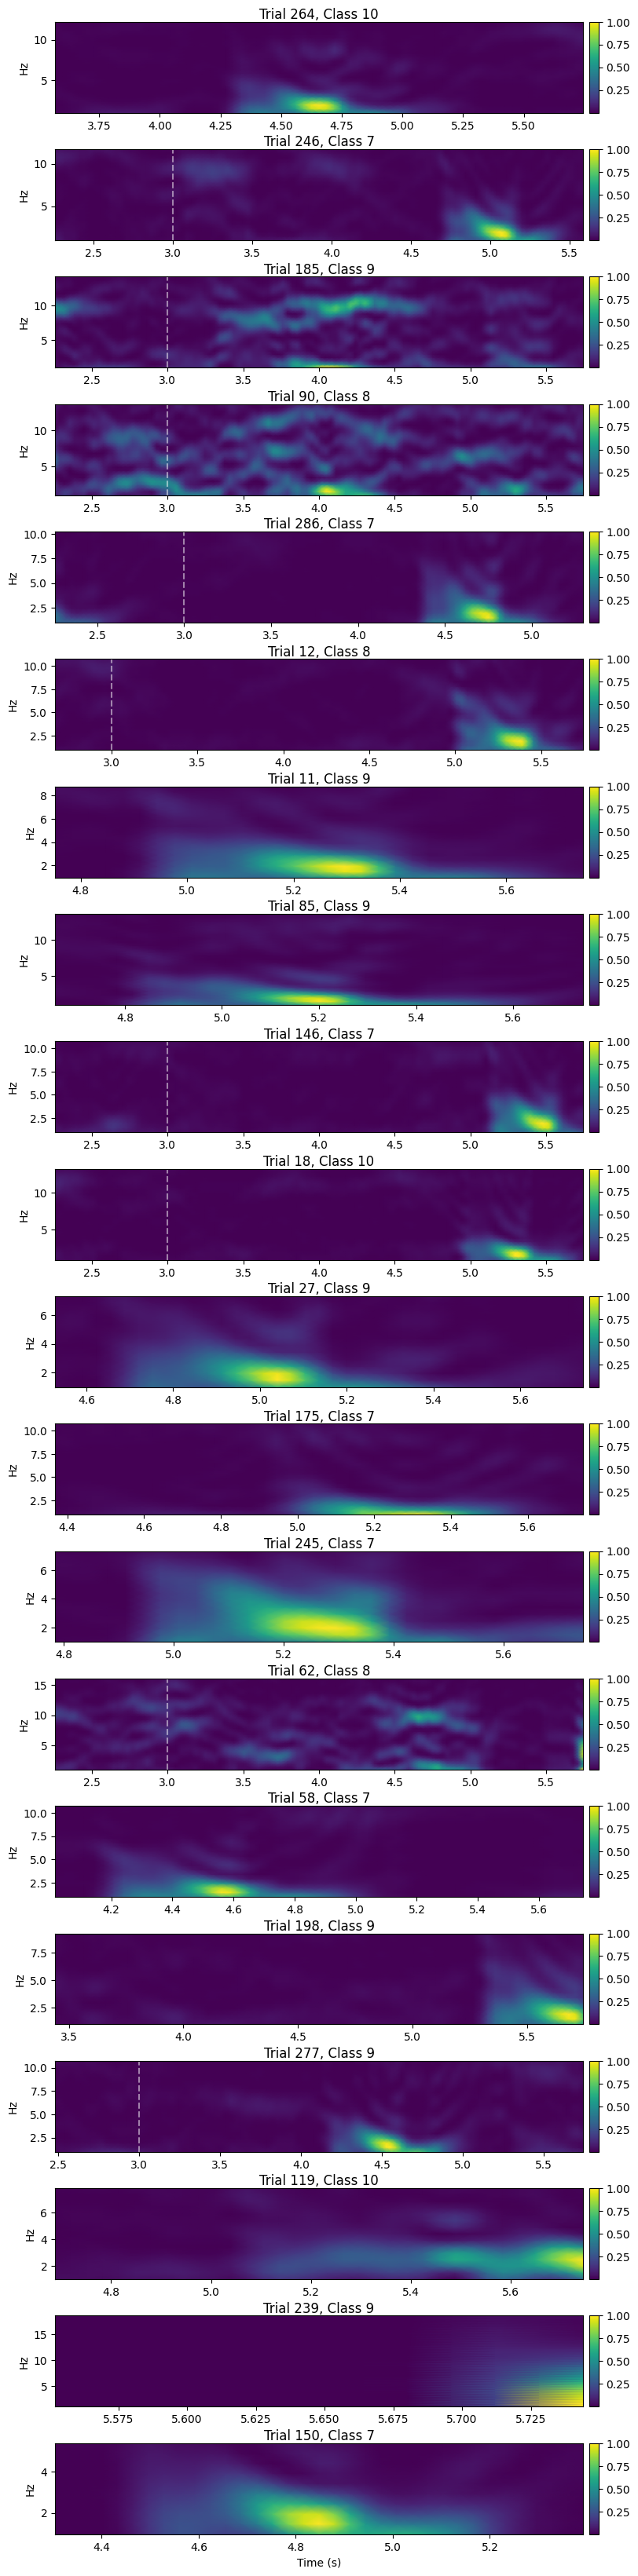

In [37]:
# Example usage
X = X_all
y = event_ids_all
# compare_all_methods(X[0, 0, :], fs=250)
# process_epochs_multitaper(X, fs=250)
# plot_class_spectrograms(X, y, fs=250)
plot_raw_spectrograms(X, y, fs=250, n_samples=20)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_array_multitaper

def plot_average_erders(X, y, fs=250):
    """
    Plot average ERD/ERS patterns for each class
    
    Args:
        X: Shape (287, 22, 1001) - trials, components, timepoints
        y: Labels
        fs: Sampling frequency
    """
    unique_classes = np.unique(y)
    
    # Calculate actual time points
    total_time = X.shape[2] / fs  # 1001 points / 250 Hz = ~4 seconds
    times = np.linspace(2, 6, X.shape[2])  # Your data is from 2-6s
    
    # Define frequency bands
    freq_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)
    }
    
    freqs = np.linspace(0.5, 45, 90)
    
    plt.figure(figsize=(20, 5*len(unique_classes)))
    
    for class_idx, class_label in enumerate(unique_classes):
        # Get trials for this class
        class_trials = X[y == class_label]
        n_trials = len(class_trials)
        
        # Calculate TFR for each trial
        all_tfr = []
        for trial in class_trials:
            data = trial[0].reshape(1, 1, -1)  # Using first component
            tfr = tfr_array_multitaper(data, sfreq=fs, freqs=freqs,
                                     n_cycles=freqs/2,
                                     time_bandwidth=2.0,
                                     use_fft=True,
                                     output='power',
                                     verbose=False)
            all_tfr.append(tfr)
        
        # Average across trials
        avg_tfr = np.mean(all_tfr, axis=0)
        
        # Calculate baseline (first 0.5s of the available data)
        n_baseline_points = int(0.5 * fs)
        baseline = np.mean(avg_tfr[:,:,:,:n_baseline_points], axis=-1)
        
        # Convert to ERD/ERS percentage
        erd_ers = (avg_tfr - baseline[:,:,:,np.newaxis]) / baseline[:,:,:,np.newaxis] * 100
        
        # Plot
        plt.subplot(len(unique_classes), 1, class_idx + 1)
        
        im = plt.pcolormesh(times, freqs, np.squeeze(erd_ers[0, 0, :, :]),
                           shading='gouraud', cmap='RdBu_r',
                           vmin=-100, vmax=100)
        
        # Add frequency band markers
        for band, (fmin, fmax) in freq_bands.items():
            plt.axhline(y=fmin, color='k', linestyle='--', alpha=0.3)
            plt.text(times[-1] + 0.1, (fmin + fmax)/2, band,
                    verticalalignment='center', fontsize=8)
        
        title = f'Class {class_label} - Average ERD/ERS Pattern (n={n_trials} trials)'
        if class_label == 7:
            title += ' - Left Hand'
        elif class_label == 8:
            title += ' - Right Hand'
        elif class_label == 9:
            title += ' - Foot'
        elif class_label == 10:
            title += ' - Tongue'
            
        plt.title(title)
        plt.ylabel('Frequency (Hz)')
        if class_idx == len(unique_classes) - 1:
            plt.xlabel('Time (s)')
        
        plt.colorbar(im, label='ERD/ERS %')
        plt.ylim([0.5, 45])
        plt.yticks(list(sum([(fmin, fmax) for fmin, fmax in freq_bands.values()], ())))
        
        # Add grid and event markers
        plt.grid(True, alpha=0.3)
        plt.axvline(x=3.0, color='k', linestyle='--', alpha=0.5, label='Cue onset')
        
        # Add legends for ERD/ERS
        plt.text(times[0]-0.1, 5, 'Blue = ERD\nRed = ERS', 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

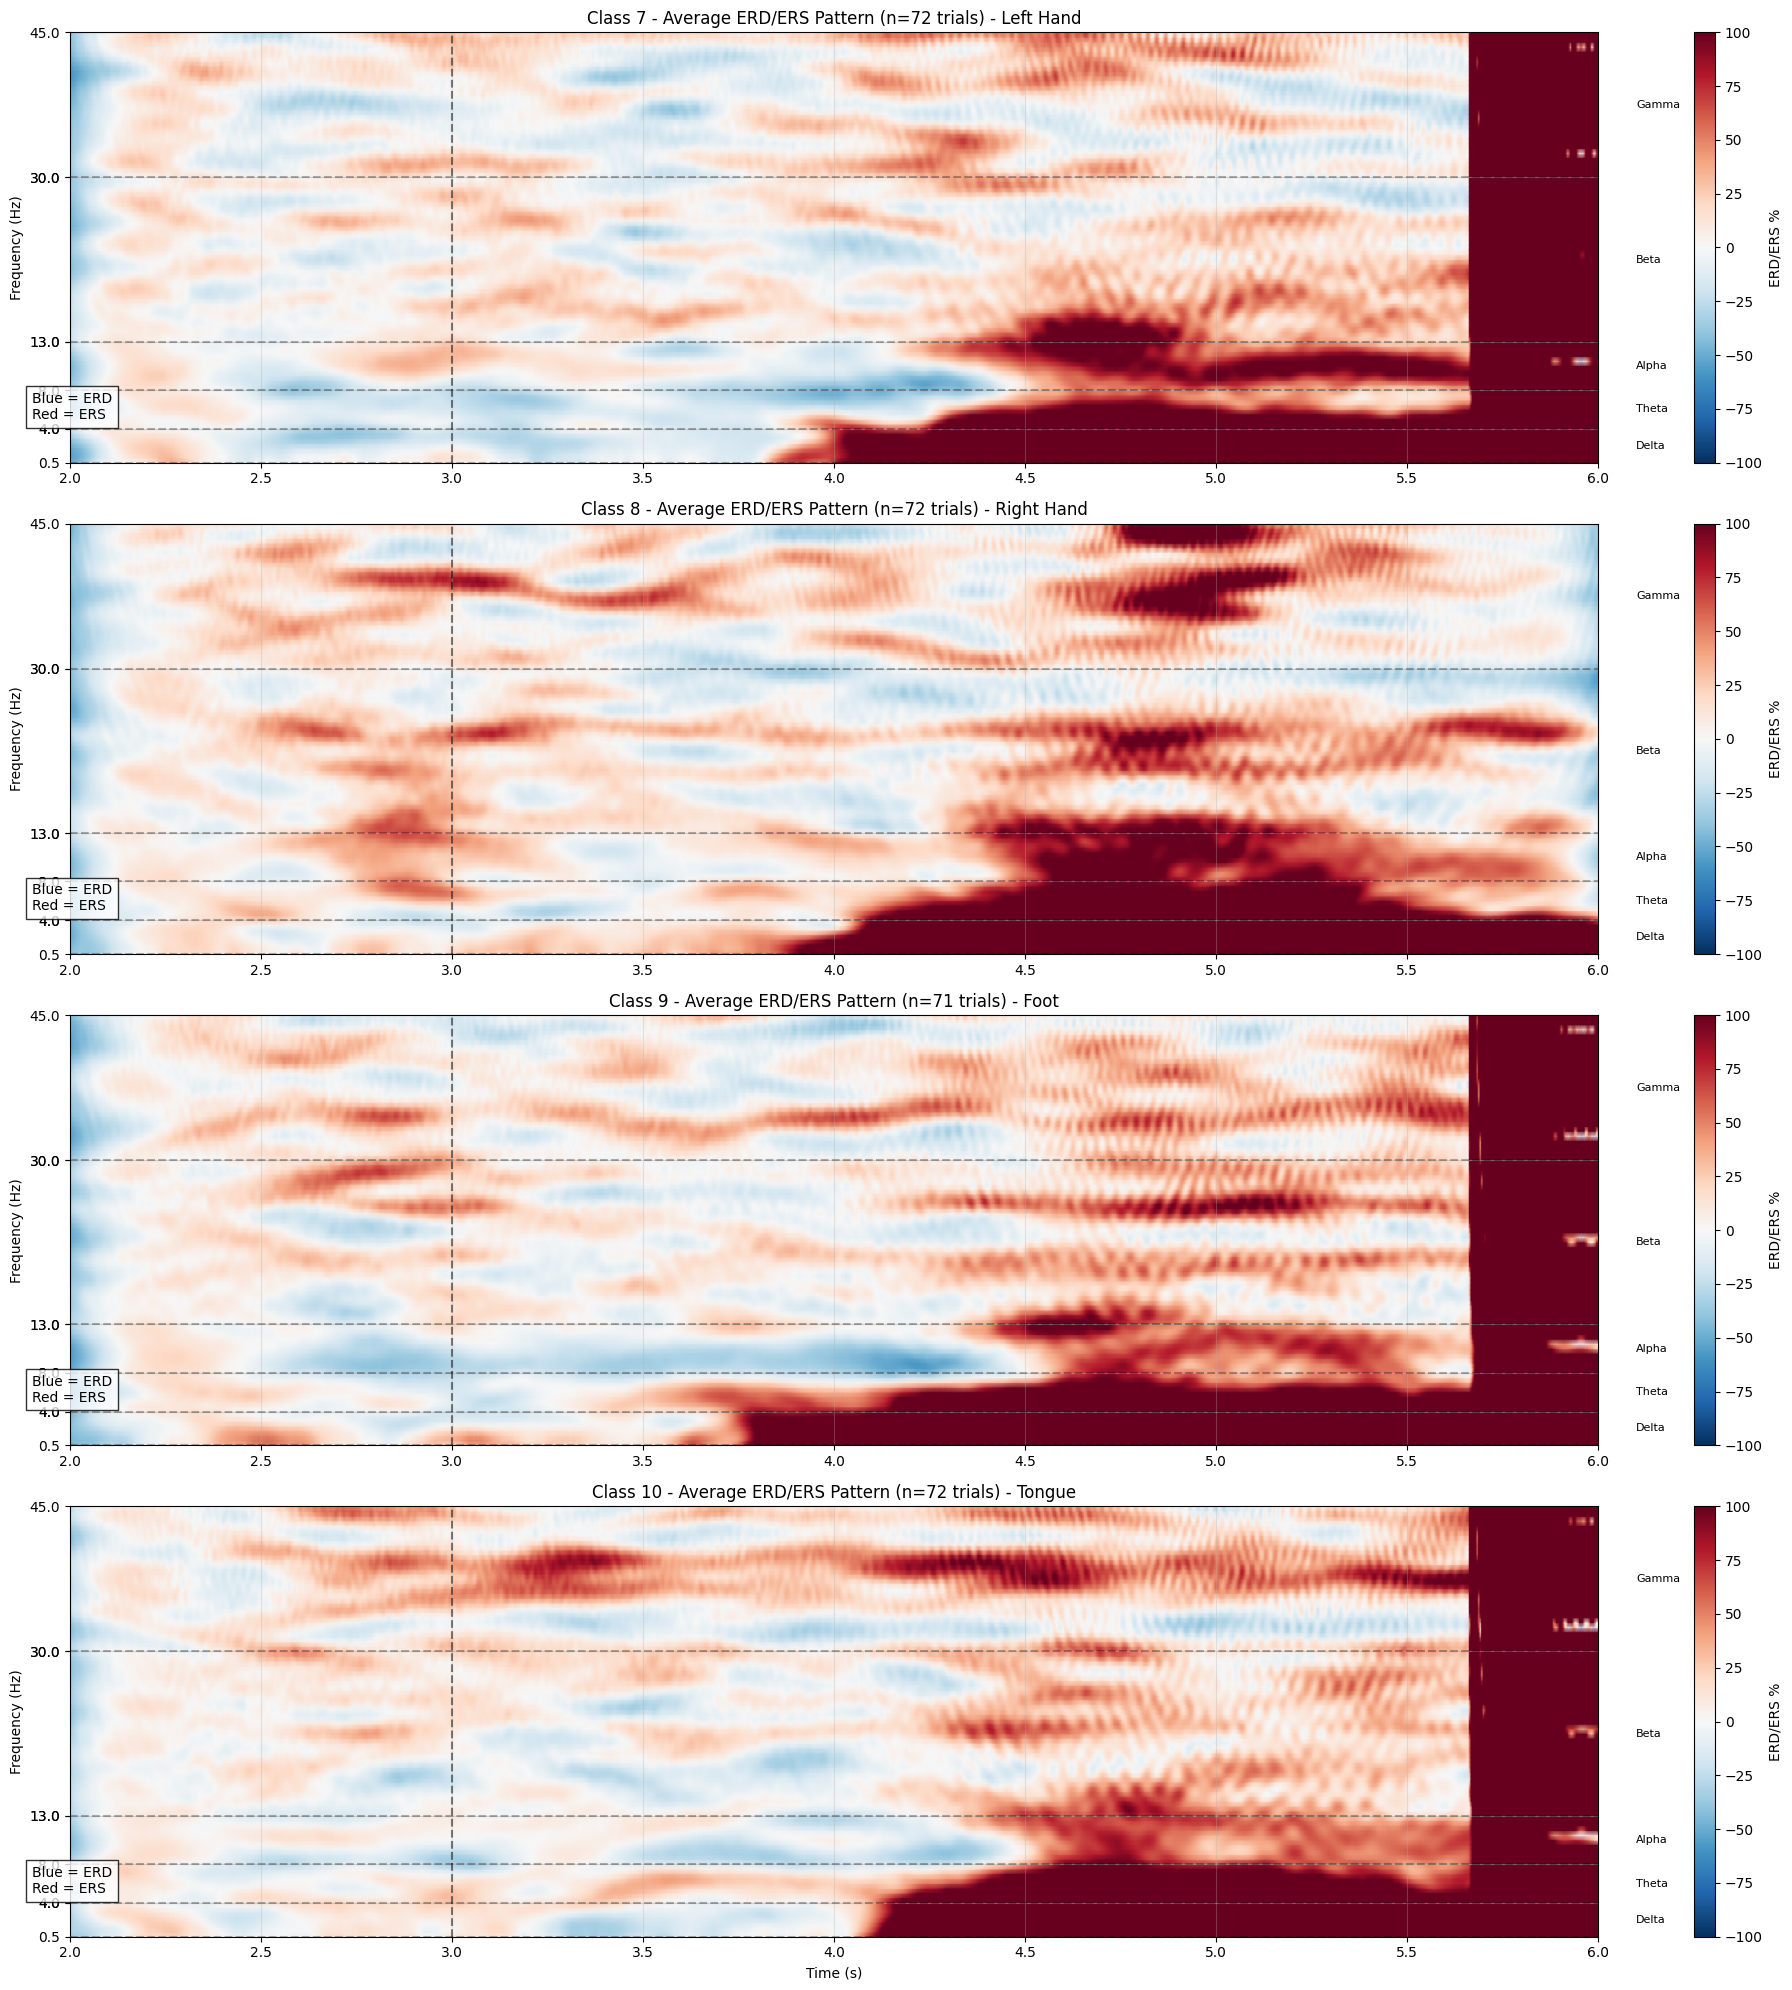

In [39]:
plot_average_erders(X, y, fs=250)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os

def save_clean_spectrograms(X, y, fs=250, window_size=64, save_path='spectrograms'):
    """
    Save clean spectrograms centered around peak activity with no markings
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    for idx in range(len(X)):
        # Compute spectrogram
        f, t, Sxx = signal.spectrogram(X[idx, 0, :], 
                                     fs=fs,
                                     nperseg=128,
                                     noverlap=120,
                                     nfft=512,
                                     detrend=False)
        
        # Focus on relevant frequencies (0.5-45 Hz)
        freq_mask = (f >= 0.5) & (f <= 45)
        Sxx = Sxx[freq_mask]
        
        # Find peak activity window
        power_per_time = Sxx.sum(axis=0)
        peak_time = np.argmax(power_per_time)
        start = max(0, peak_time - window_size//2)
        end = min(Sxx.shape[1], start + window_size)
        
        # Extract window around peak
        Sxx_peak = Sxx[:, start:end]
        
        # Normalize to [0, 1]
        Sxx_peak = (Sxx_peak - Sxx_peak.min()) / (Sxx_peak.max() - Sxx_peak.min())
        
        # Create clean figure
        plt.figure(figsize=(3, 3))
        plt.imshow(Sxx_peak, aspect='auto', cmap='viridis')
        
        # Remove everything except the spectrogram
        plt.axis('off')
        plt.margins(0,0)
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        
        # Save with high dpi for quality
        plt.savefig(f'{save_path}/trial_{idx}_class_{y[idx]}.png', 
                   bbox_inches='tight', 
                   pad_inches=0,
                   dpi=300)
        plt.close()

# Usage:
# save_clean_spectrograms(X, y, save_path='spectrograms')

In [42]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os

# Define scales for CWT
scales = np.arange(1, 64)  # Adjust scales for resolution as needed
waveletname = 'morl'

# Function to generate CWT images from EEG data
def generate_cwt_images(data, labels, save_path='cwt_images'):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Loop through each sample and its label
    for sample_idx in range(data.shape[0]):
        sample = data[sample_idx]
        label = labels[sample_idx]

        # Create a directory for each label
        label_dir = os.path.join(save_path, f"class_{label}")
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        # Generate CWT for each channel and save as a multi-channel "image"
        cwt_images = []
        for channel_idx in range(sample.shape[0]):  # 22 channels
            channel_data = sample[channel_idx, :]  # Shape (1001,)
            coefficients, _ = pywt.cwt(channel_data, scales, waveletname)
            
            # Take absolute values to use as image data and resize to 128x128 for CNN
            cwt_image = np.abs(coefficients)
            cwt_image_resized = np.resize(cwt_image, (128, 128))  # Resize to 128x128
            
            cwt_images.append(cwt_image_resized)

        # Stack images along the depth axis to create a "22-channel image"
        cwt_image_stack = np.stack(cwt_images, axis=-1)  # Shape (128, 128, 22)
        
        # Save each stack as a .npy file (better for multi-channel data)
        np.save(os.path.join(label_dir, f"sample_{sample_idx}.npy"), cwt_image_stack)

# Assuming `data` is your EEG data array of shape (287, 22, 1001)
# and `labels` is your labels array of shape (287,)
generate_cwt_images(X_all, event_ids_all)


Label: ['cwt_images', 'class_10', 'sample_154.npy']
Label: ['cwt_images', 'class_9', 'sample_24.npy']
Label: ['cwt_images', 'class_7', 'sample_202.npy']
Label: ['cwt_images', 'class_9', 'sample_66.npy']
Label: ['cwt_images', 'class_10', 'sample_77.npy']
Label: ['cwt_images', 'class_7', 'sample_67.npy']
Label: ['cwt_images', 'class_7', 'sample_5.npy']
Label: ['cwt_images', 'class_10', 'sample_242.npy']
Label: ['cwt_images', 'class_10', 'sample_156.npy']
Label: ['cwt_images', 'class_10', 'sample_105.npy']


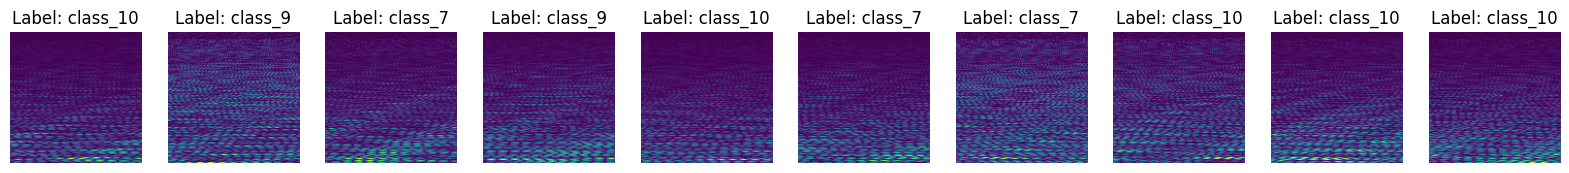

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

def visualize_random_cwt_images(data_dir, num_images=5):
    # List all files in the data directory
    all_files = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        files = [os.path.join(label_path, f) for f in os.listdir(label_path)]
        all_files.extend(files)

    # Randomly select files to visualize
    selected_files = random.sample(all_files, num_images)

    plt.figure(figsize=(20, 20))
    for i, file_path in enumerate(selected_files):
        cwt_image = np.load(file_path)  # Load .npy file
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cwt_image[:, :, 0], cmap='viridis')  # Display first channel as an example
        plt.axis('off')
        print(f"Label: {file_path.split("\\")}")
        plt.title(f"Label: {file_path.split("\\")[-2]}")
    plt.show()

# Visualize random CWT images
visualize_random_cwt_images('cwt_images', num_images=10)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 22)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=[])

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Plot training history
plot_training_history(history)
